# Image Segmentation with FastAI.vision
Below is my jupyter notebook for the solution presented by Senseye's Coding Challenge. The general idea was to make a program capable of generating masks. This solution is broken up into 3 parts:
   1. Creating a DataBunch from provided masks and imgs and separating into training and validation sets
   2. Creating Model, determining appropriate learning rate, and then training the model
   3. Outputting mask that is the same as original inputs, (i.e. BW image)
This process will then be moved to a command-line application that will allow a user to input their own images, and receive each mask as an output.

Much of this code is available on FastAI's tutorials at docs.fast.ai and provided references from Senseye's readme doc

In [1]:
#Imports
from fastai.vision import *
import random
import numpy as np
import os

#Set path to current directory for later referencing
path = untar_data(r"C:\Users\Owner\Senseye_Coding_Challenge\Senseye_Coding_Task_Machine_Learning")


# Part 1 : Setting up Data
Below we will set up our image and mask paths as well as take a look at what the images look like. Immediately following we have a few functions that FastAI requires us to set up (get_y_fn, mask) as well as another function I set myself to create our validation data.

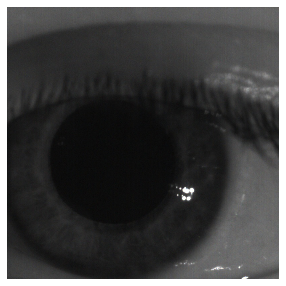

In [2]:
#Set paths to masks and imgs
path_lbl = path/'masks_small'
path_img = path/'imgs_small'


fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

# open and show image
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [3]:
#function required by FastAI to get paths to each image in masks
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'
print(get_y_fn(img_f))

C:\Users\Owner\Senseye_Coding_Challenge\Senseye_Coding_Task_Machine_Learning\masks_small\set_11_frame_3.png


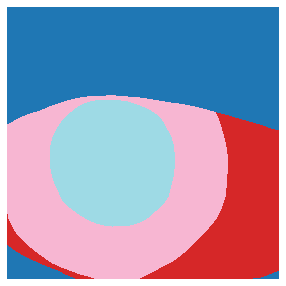

In [4]:
#Function to open respective masks based on original image
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
#My own function to randomly create validation list ("valid.txt")
def create_segments(path_to_img, pct = 0.10):
    """
    Function to create valid.txt to randomly select validation set.
    10% is the default value
    
    arguments: WindowsPath Object to img folder
    returns: None
    """
    
    mask_list = os.listdir(path_to_img)
    num_files = int(len(mask_list)*pct)
    valid_list = random.sample(mask_list, num_files)
    outF = open("valid.txt", "w")
    for line in valid_list:
        outF.write(line)
        outF.write("\n")
    outF.close()


In [6]:
#Codes based on readme inputed into codes.txt with Void as additional code
codes = np.loadtxt(path/'codes.txt', dtype=str) # Load data codes
src_size = np.array(mask.shape[1:])
size = src_size//2
create_segments(path_img)

#Create DataBunch
src = (SegmentationItemList.from_folder(path_img)
       
       # Load in x data from folder
       .split_by_fname_file('../valid.txt')
       # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)
       # Label data using the get_y_fn function
)

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        # Flip images horizontally
        .databunch(bs=10, path = path)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)


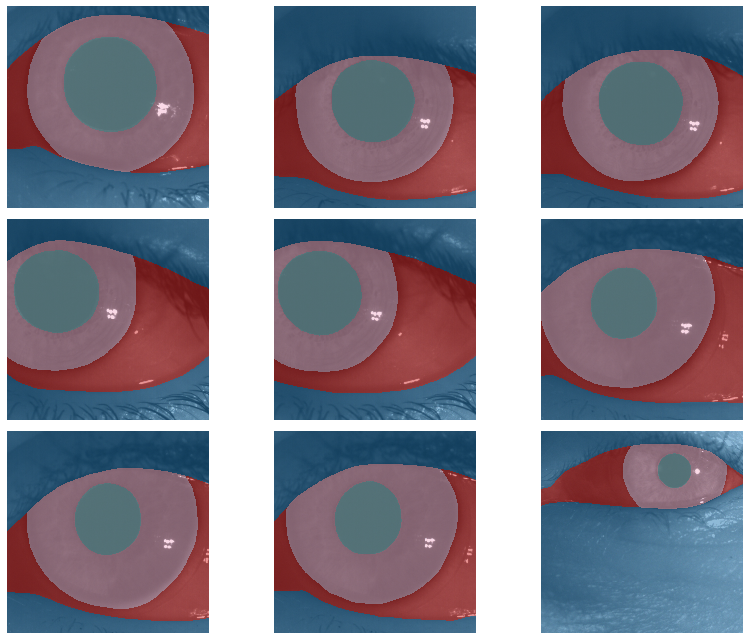

In [7]:
#Images from our Validation set, randomly picked
data.show_batch(rows=2, figsize=(12, 9), ds_type = DatasetType.Valid)


# Part 2: Model Training
Here we will instantiate our model object using resnet18. I am using resnet18 as that is the largest my current system is capable of supporting on my GPU. Our accuracy metric is pulled from this tutorial: https://towardsdatascience.com/fastai-image-segmentation-eacad8543f6f

Then, we will determine a learning rate using lr_find and plot(). The learning rate will be inputed into our model and we will train for 10 epochs. (usually would do more but for this purpose I will keep it at 10)

In [8]:
#Function to determine our accuracy during training
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc (input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim = 1)[mask] == target[mask]).float().mean()

#Build our model with name learn based on resnet18
learn = unet_learner(data, models.resnet18, metrics = acc, wd = 1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


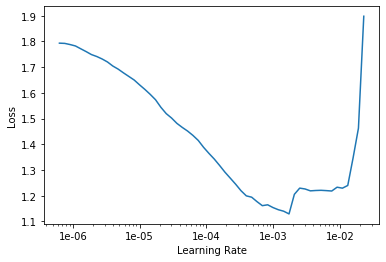

In [9]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [10]:
#Training only the classifier initially 
lr = 2e-3 # pick a lr
learn.fit_one_cycle(10, lr) # train model

epoch,train_loss,valid_loss,acc,time
0,0.506498,0.413778,0.848780,01:06
1,0.285149,0.175298,0.935590,01:05
2,0.193571,0.089566,0.968639,01:05
3,0.123505,0.068774,0.975009,01:04
4,0.087455,0.057283,0.978627,01:02
5,0.068031,0.056183,0.978948,01:05
6,0.057045,0.052300,0.980037,01:04
7,0.050346,0.049507,0.980924,01:06
8,0.046554,0.049788,0.981042,01:04
9,0.044632,0.048247,0.981474,01:06


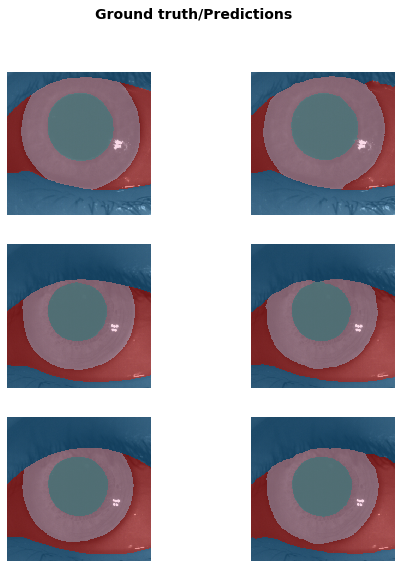

In [11]:
#Show our current results from holding all layers except classification the same,
#Save model in case training entire model produces worse results
model_name = 'stage-1'
learn.save(model_name) # save model
learn.show_results(rows=3, figsize=(8, 9)) # show results

In [12]:
# Unfreeze all layers and train entire model
learn.unfreeze()
learn.load(model_name)
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,acc,time
0,0.054776,0.384041,0.906407,01:10
1,0.175588,1.793929,0.739731,01:07
2,0.227758,0.809388,0.738832,01:05
3,0.297452,0.445608,0.846247,01:04
4,0.269264,0.162876,0.947869,01:02
5,0.183612,0.093199,0.967169,01:03
6,0.123762,0.071346,0.973394,01:05
7,0.090118,0.063088,0.975528,01:04
8,0.072948,0.057685,0.977558,01:05
9,0.064292,0.057406,0.977647,01:05


# Part 3: Final Output
Below is the solution to the problem statements for the purposes of this jupyter notebook. We take a random image from our train set, and run a prediction. This will give us a mask overlayed on the original image. FastAI includes a save function for the mask that will produce the final product for us. The code below will save test.png mask into test_folder located in the same directory as this notebook. Then we output what the final product looks like.

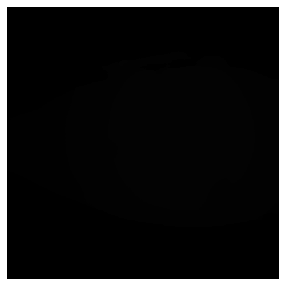

In [19]:
#Produce final mask and display result, save into new folder named test_folder
img = data.train_ds[0][0]
y = learn.predict(img)[0]
y.save("test_folder/test.png")
path_test = path/'test_folder'
test_img = get_image_files(path_test)[0]
img_test = open_image(test_img)
img_test.show(figsize=(5, 5))

In [20]:
type(img)

fastai.vision.image.Image

# Conclusion
As we attempted to train the entire model, we ended up with a worse result, thus in the final application, we will elect to only train the classification layer.